<a href="https://colab.research.google.com/github/Jiwei-Cao/Recyclo/blob/main/notebooks/recyclo_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Regular imports
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from pathlib import Path
import os
import zipfile
import requests
import shutil
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [ ]:
# Download trashnet dataset
data_100_percent_path = download_data(source="https://github.com/Jiwei-Cao/Recyclo/raw/refs/heads/main/data/trashnet.zip",
                                      destination="trashnet_100_percent")

[INFO] Did not find data/trashnet_100_percent directory, creating one...
[INFO] Downloading trashnet.zip from https://github.com/Jiwei-Cao/Recyclo/raw/refs/heads/main/data/trashnet.zip...
[INFO] Unzipping trashnet.zip data...


In [ ]:
# Split the dataset into 20% training data and 80% testing data
base_dir = Path("data/trashnet_100_percent")
src_dir = Path(base_dir / "dataset-resized")
train_dir = Path(base_dir / "train")
test_dir = Path(base_dir / "test")

for class_folder in src_dir.iterdir():
  if class_folder.is_dir():
    images = list(class_folder.glob("*"))
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Create class folders in train and test
    train_class_dir = train_dir / class_folder.name
    test_class_dir = test_dir / class_folder.name
    train_class_dir.mkdir(parents=True, exist_ok=True)
    test_class_dir.mkdir(parents=True, exist_ok=True)

    # Copy files
    for img in train_images:
      shutil.copy(img, train_class_dir / img.name)
    for img in test_images:
      shutil.copy(img, test_class_dir / img.name)

# Delete unfiltered dataset file
path_to_delete = Path("data/trashnet_100_percent/dataset-resized")

if path_to_delete.exists() and path_to_delete.is_dir():
  shutil.rmtree(path_to_delete)
  print(f"Deleted: {path_to_delete}")
else:
  print(f"Folder not found or not a directory: {path_to_delete}")

Deleted: data/trashnet_100_percent/dataset-resized


In [ ]:
# Create trashnet_20_percent
src_dir = Path("data/trashnet_100_percent")
src_train = src_dir / "train"
src_test = src_dir / "test"
dst_dir = Path("data/trashnet_20_percent")
dst_train = dst_dir / "train"
dst_test = dst_dir / "test"

dst_train.mkdir(parents=True, exist_ok=True)
dst_test.mkdir(parents=True, exist_ok=True)

# Copy 20% of training data
for class_dir in src_train.iterdir():
  if class_dir.is_dir():
    images = list(class_dir.glob("*"))
    random.shuffle(images)
    sample_count = int(len(images) * 0.2)
    selected_images = images[:sample_count]

    dst_class_dir = dst_train / class_dir.name
    dst_class_dir.mkdir(parents=True, exist_ok=True)

    for img in selected_images:
      shutil.copy(img, dst_class_dir / img.name)

# Copy all of test data
for class_dir in src_test.iterdir():
  if class_dir.is_dir():
    dst_class_dir = dst_test / class_dir.name
    dst_class_dir.mkdir(parents=True, exist_ok=True)

    for img in class_dir.glob("*"):
      shutil.copy(img, dst_class_dir / img.name)

In [ ]:
# Setup train and test paths
data_20_percent_path = Path("data/trashnet_20_percent")
train_dir_20_percent = data_20_percent_path / "train"
test_dir_20_percent = data_20_percent_path / "test"

train_dir_20_percent, test_dir_20_percent

(PosixPath('data/trashnet_20_percent/train'),
 PosixPath('data/trashnet_20_percent/test'))

In [ ]:
# Creating an EffNetB2 feature extractor
def create_effnetb2_model(num_classes:int,
                          freeze_until: int=5):
  # Create EffNetB2 pretrained weights, transform and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transform = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze early stages
  for name, param in model.named_parameters():
    stage_idx = int(name.split(".")[1])
    if stage_idx <= freeze_until:
      param.requires_grad = False
    else:
      param.requires_grad = True

  # Change classifier head
  in_feats = model.classifier[1].in_features
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=in_feats, out_features=num_classes)
  )

  return model, transform

In [ ]:
recyclo_20_percent, recyclo_20_percent_transforms = create_effnetb2_model(num_classes=6)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 146MB/s]


In [ ]:
summary(model=recyclo_20_percent,
        input_size=(1, 3, 260, 260),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 260, 260]     [1, 6]               --                   Partial
├─Sequential (features)                                      [1, 3, 260, 260]     [1, 1408, 9, 9]      --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 260, 260]     [1, 32, 130, 130]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 260, 260]     [1, 32, 130, 130]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 130, 130]    [1, 32, 130, 130]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 130, 130]    [1, 32, 130, 130]    --                   --
│    └─Sequential (1)                                        [1, 32, 130, 130]    [1,

In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_recyclo_20_percent, test_dataloader_recyclo_20_percent, class_names = create_dataloaders(train_dir=train_dir_20_percent,
                                                                                      test_dir=test_dir_20_percent,
                                                                                      train_transform=recyclo_20_percent_transforms,
                                                                                      test_transform=recyclo_20_percent_transforms,
                                                                                      batch_size=32)
len(train_dataloader_recyclo_20_percent), len(test_dataloader_recyclo_20_percent)

(13, 16)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    (0.1112, 0.8743)
  """

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0223, 0.8985)
  """

  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
# Training the recyclo_20_percent feature extractor
NUM_EPOCHS = 10

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, recyclo_20_percent.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

recyclo_20_percent_results = train(model=recyclo_20_percent.to(device),
                         train_dataloader=train_dataloader_recyclo_20_percent,
                         test_dataloader=test_dataloader_recyclo_20_percent,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS,
                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6764 | train_acc: 0.3480 | test_loss: 1.5438 | test_acc: 0.5781
Epoch: 2 | train_loss: 1.3222 | train_acc: 0.7281 | test_loss: 1.2949 | test_acc: 0.6936
Epoch: 3 | train_loss: 1.0131 | train_acc: 0.8130 | test_loss: 1.0766 | test_acc: 0.7327
Epoch: 4 | train_loss: 0.7574 | train_acc: 0.8654 | test_loss: 0.9051 | test_acc: 0.7447
Epoch: 5 | train_loss: 0.5552 | train_acc: 0.9145 | test_loss: 0.7843 | test_acc: 0.7642
Epoch: 6 | train_loss: 0.4422 | train_acc: 0.9193 | test_loss: 0.6904 | test_acc: 0.7946
Epoch: 7 | train_loss: 0.3178 | train_acc: 0.9468 | test_loss: 0.6312 | test_acc: 0.8103
Epoch: 8 | train_loss: 0.2610 | train_acc: 0.9567 | test_loss: 0.5944 | test_acc: 0.8239
Epoch: 9 | train_loss: 0.1815 | train_acc: 0.9789 | test_loss: 0.5676 | test_acc: 0.8320
Epoch: 10 | train_loss: 0.1336 | train_acc: 0.9928 | test_loss: 0.5538 | test_acc: 0.8281


In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

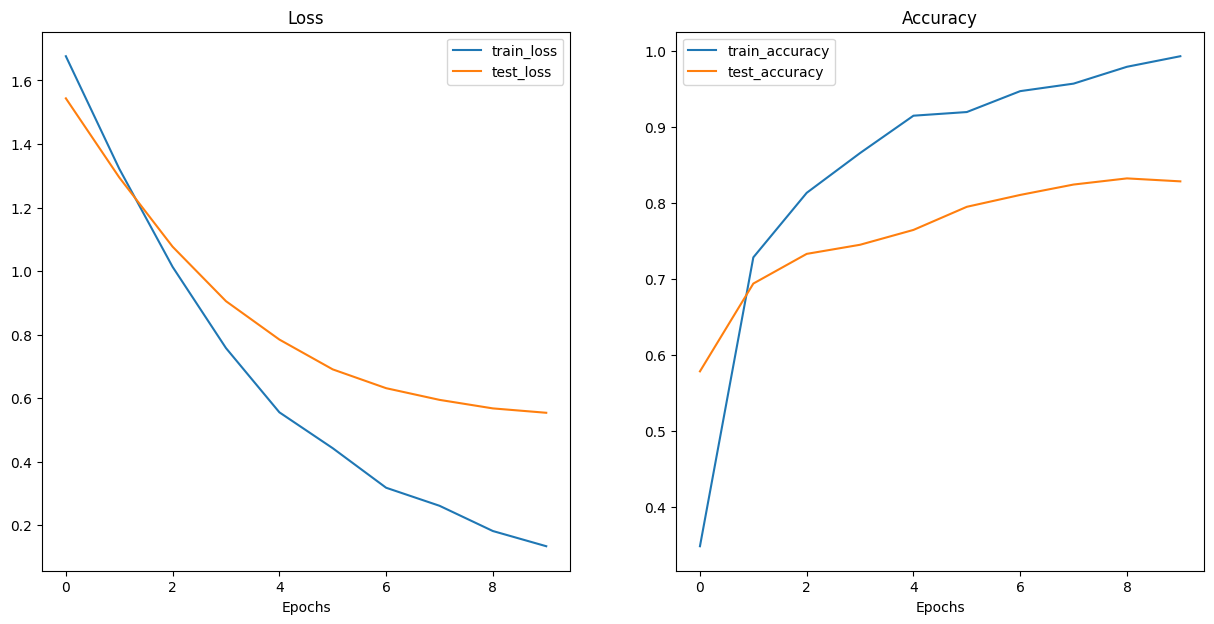

In [ ]:
plot_loss_curves(recyclo_20_percent_results)

In [ ]:
# Creating Recyclo Model with 100% of the data
recyclo, recyclo_transforms = create_effnetb2_model(num_classes=6)

In [ ]:
data_100_percent_path = Path("data/trashnet_100_percent")
train_dir_100_percent = data_100_percent_path / "train"
test_dir_100_percent = data_100_percent_path / "test"

train_dir, test_dir

(PosixPath('data/trashnet_100_percent/train'),
 PosixPath('data/trashnet_100_percent/test'))

In [ ]:
# Create training data transforms with data augmentation (only for training data)
recyclo_train_transforms = torchvision.transforms.Compose([
    transforms.RandomResizedCrop(260, scale=(0.8, 1.0)),
    transforms.RandAugment(),
    recyclo_transforms
])

recyclo_train_transforms

Compose(
    RandomResizedCrop(size=(260, 260), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# Testing data transform (no augmentation for testing data)
recyclo_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Setup dataloaders
train_dataloader_recyclo_100_percent, test_dataloader_recyclo_100_percent, class_names = create_dataloaders(train_dir=train_dir_100_percent,
                                                                                      test_dir=test_dir_100_percent,
                                                                                      train_transform=recyclo_train_transforms,
                                                                                      test_transform=recyclo_transforms,
                                                                                      batch_size=32)
len(train_dataloader_recyclo_100_percent), len(test_dataloader_recyclo_100_percent)

(64, 16)

In [ ]:
# Training recyclo
NUM_EPOCHS = 15

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, recyclo.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

recyclo_results = train(model=recyclo.to(device),
                        train_dataloader=train_dataloader_recyclo_100_percent,
                        test_dataloader=test_dataloader_recyclo_100_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3738 | train_acc: 0.5933 | test_loss: 0.9700 | test_acc: 0.7829
Epoch: 2 | train_loss: 0.8822 | train_acc: 0.8115 | test_loss: 0.7810 | test_acc: 0.8518
Epoch: 3 | train_loss: 0.7179 | train_acc: 0.8857 | test_loss: 0.6998 | test_acc: 0.8823
Epoch: 4 | train_loss: 0.6607 | train_acc: 0.9028 | test_loss: 0.6599 | test_acc: 0.8982
Epoch: 5 | train_loss: 0.5965 | train_acc: 0.9346 | test_loss: 0.6307 | test_acc: 0.9040
Epoch: 6 | train_loss: 0.5690 | train_acc: 0.9489 | test_loss: 0.6092 | test_acc: 0.9129
Epoch: 7 | train_loss: 0.5537 | train_acc: 0.9543 | test_loss: 0.6054 | test_acc: 0.9116
Epoch: 8 | train_loss: 0.5361 | train_acc: 0.9635 | test_loss: 0.5925 | test_acc: 0.9171
Epoch: 9 | train_loss: 0.5276 | train_acc: 0.9679 | test_loss: 0.5953 | test_acc: 0.9096
Epoch: 10 | train_loss: 0.5144 | train_acc: 0.9756 | test_loss: 0.5909 | test_acc: 0.9074
Epoch: 11 | train_loss: 0.4994 | train_acc: 0.9824 | test_loss: 0.5982 | test_acc: 0.9099
Epoch: 12 | train_l

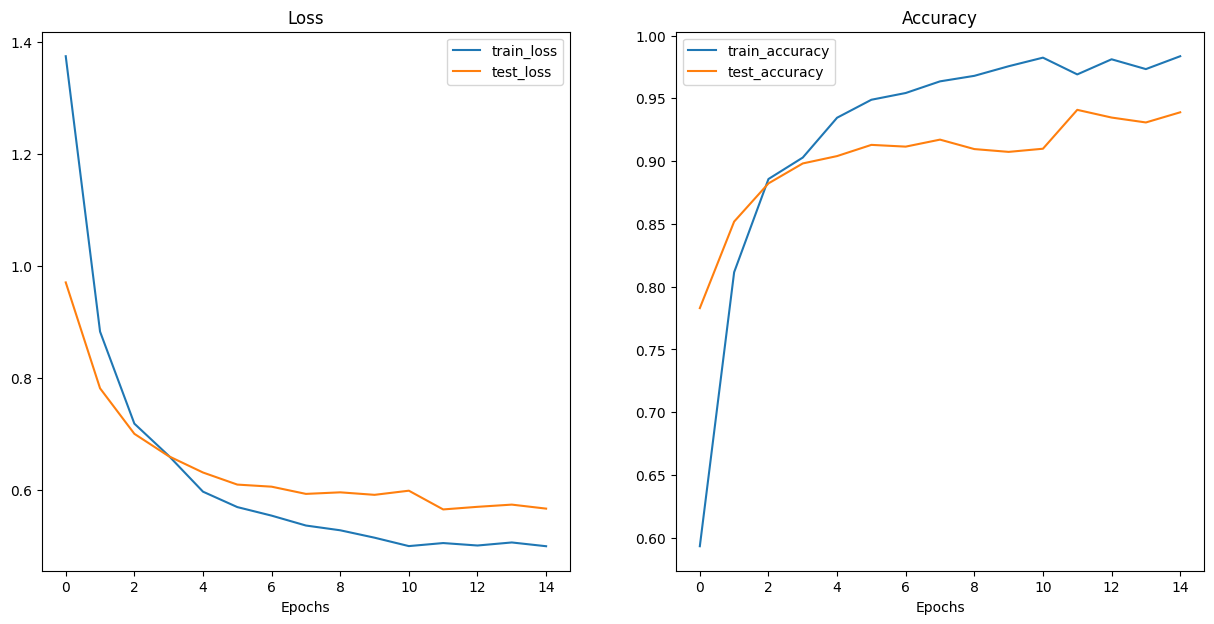

In [ ]:
plot_loss_curves(recyclo_results)

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
# Create a model path for recyclo
recyclo_model_path = "recyclo_model.pth"

# Save model
save_model(model=recyclo,
           target_dir="models/",
           model_name=recyclo_model_path)

[INFO] Saving model to: models/recyclo_model.pth


In [31]:
# Check recyclo model size
recyclo_model_size = Path("models", recyclo_model_path).stat().st_size // (1024 * 1024)
print(f"Recyclo model size: {recyclo_model_size}MB")

Recyclo model size: 29MB


In [32]:
# Download recyclo model
try:
  from google.colab import files
  files.download("models/recyclo_model.pth")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download recyclo_model.pth manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>